In this notebook, we assume that 5 instances of each of the 4 models have already been pre-trained on the Fontainebleau area. The weights of the pre-trained instances are loaded from the 'Sentinel_model_weigths' folder. Alternatively, the training can be reproduced using the 'Sentinel_training' notebook.

# Imports

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import copy as cp
from time import time
import math

# import torch
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import autograd
import torch.cuda
from torch.func import stack_module_state, vmap, functional_call
import gc

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

try :
  print(torch.cuda.get_device_name(0))
except :
  print("No GPU is available.")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def mse_loss(x, x_hat):
    """
    Calculate the Mean Squared Error (MSE) loss between input and reconstructed data.

    Args:
        x (torch.Tensor): Input data.
        x_hat (torch.Tensor): Reconstructed data.

    Returns:
        torch.Tensor: Mean squared error loss.
    """
    total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
    return total_prediction_loss

cuda:0
NVIDIA A100-SXM4-40GB


In [2]:
!git clone https://github.com/42anonymous42/AIKAE

Cloning into 'AIKAE'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 80 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (80/80), 18.60 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
from AIKAE.models import KoopmanAE, IKAE, IKAE_zp, AIKAE, NICE, RealNVP

In [4]:
def rescale(im, minim=None, maxim=None):
    if maxim is None :
      maxim = np.amax(im)
    if minim is None :
      minim = np.amin(im)
    return (im-minim)/(maxim-minim)

In [5]:
def truncate(im):
  im[im < 0] = 0
  im[im > 1] = 1
  return im

In [6]:
def mse_loss(x, x_hat):
  total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
  return total_prediction_loss

# Import data with gdown

Running the cell below enables you to download the Sentinel-2 data directly from Google Drive. Another option is to download the files from https://drive.google.com/drive/u/1/folders/1doHnjryCMptkzxYFfw-ILwAD0tOK3LGH and then use them at will, either locally or on a Google Colab session.

In [7]:
# Fontainebleau interpolated time series
!gdown 1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo -O Fontainebleau_interpolated.npy

# Orléans irregular time series and its mask
!gdown 1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710 -O Orléans_irregular.npy
!gdown 17IjvRhWT4dzyr9vlKQOjoolYAzTvLfvF -O Orléans_mask.npy

Downloading...
From (original): https://drive.google.com/uc?id=1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo
From (redirected): https://drive.google.com/uc?id=1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo&confirm=t&uuid=04a7c6f5-e1eb-4e64-9673-9d62c096e025
To: /content/Fontainebleau_interpolated.npy
100% 3.43G/3.43G [01:07<00:00, 50.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710
From (redirected): https://drive.google.com/uc?id=1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710&confirm=t&uuid=6698d928-5e46-4cb5-af78-1508830b20c4
To: /content/Orléans_irregular.npy
100% 3.43G/3.43G [00:50<00:00, 68.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=17IjvRhWT4dzyr9vlKQOjoolYAzTvLfvF
To: /content/Orléans_mask.npy
100% 2.87k/2.87k [00:00<00:00, 13.5MB/s]


In [8]:
data = np.load('Fontainebleau_interpolated.npy')
max_Fontainebleau = np.max(data)

In [9]:
# We rescale the data to values between 0 and 1
if np.max(data) > 1:
  data /= max_Fontainebleau
  data *= 3 # Arbitrary rescaling and thresholding since the max is highly saturated
  data[data > 1] = 1

In [10]:
print(data.shape)
#343 -> temporal index ; 10 -> spectral band index ; 500, 500 -> spatial indexes

(343, 10, 500, 500)


In [11]:
data_test = np.load('Orléans_irregular.npy')
mask_test = np.load('Orléans_mask.npy')

In [12]:
# We rescale the data to values between 0 and 1
if np.max(data_test) > 3:
  data_test /= max_Fontainebleau
  data_test *= 3 # Arbitrary rescaling since the max is highly saturated
  # This time we do not impose a threshold of 1

In [13]:
# We extract 150x150 squares out of the 500x500 pixel time series

data_small = data[:,:,250:350,250:350].transpose(0,2,3,1) #150x150
reflectances = data_small.transpose(3,1,2,0)

data_test_small = data_test[:,:,150:250,150:250].transpose(0,2,3,1) #150x150
reflectances_test = data_test_small.transpose(3,1,2,0)

# Testing

## Assimilation-forecasting Fontainebleau

### KAE

In [14]:
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

In [15]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/KAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
  final_losses.append(0)
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]-1))#.to(device)for step in range(steps):
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    epochs = 201
    #epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis.flatten(0,1)).reshape((time_span+1, size//steps, size, 20)).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,1:time_span+2])
      loss.backward()
      opt.step()
      if epoch % 20 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(predictions.shape[-1]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis.flatten(0,1)).reshape((predictions.shape[-1], size//steps, size, 20)).permute((3,1,2,0))
    predictions[:,k*(size//steps):(k+1)*(size//steps),:,:] = decoded.cpu().detach()

  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:])
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25


<ipython-input-15-024737f5ab60>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 0 : loss 504.4412536621094
Epoch 20 : loss 93.77278900146484
Epoch 40 : loss 69.71651458740234
Epoch 60 : loss 63.5949821472168
Epoch 80 : loss 61.4676628112793
Epoch 100 : loss 60.49453353881836
Epoch 120 : loss 59.94145584106445
Epoch 140 : loss 59.58673858642578
Epoch 160 : loss 59.370391845703125
Epoch 180 : loss 59.21455001831055
Epoch 200 : loss 59.11164474487305
Columns 25 to 50
Epoch 0 : loss 576.7379150390625
Epoch 20 : loss 90.1787338256836
Epoch 40 : loss 64.55007934570312
Epoch 60 : loss 57.78573226928711
Epoch 80 : loss 55.4463005065918
Epoch 100 : loss 54.39217758178711
Epoch 120 : loss 53.818023681640625
Epoch 140 : loss 53.44832992553711
Epoch 160 : loss 53.187347412109375
Epoch 180 : loss 53.00539016723633
Epoch 200 : loss 52.874176025390625
Columns 50 to 75
Epoch 0 : loss 807.8004150390625
Epoch 20 : loss 115.65166473388672
Epoch 40 : loss 83.4813003540039
Epoch 60 : loss 74.58173370361328
Epoch 80 : loss 71.45565032958984
Epoch 100 : loss 70.0030746459961
Epoch

Expected result -> MSE: 0.0011231523938477039, MAE: 0.021348286792635916

### IKAE

In [16]:
model = IKAE.IKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [17]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
  final_losses.append(0)
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]-1))#.to(device)for step in range(steps):
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    epochs = 201
    #epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis.flatten(0,1)).reshape((time_span+1, size//steps, size, 20)).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,1:time_span+2])
      loss.backward()
      opt.step()
      if epoch % 20 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(predictions.shape[-1]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis.flatten(0,1)).reshape((predictions.shape[-1], size//steps, size, 20)).permute((3,1,2,0))
    predictions[:,k*(size//steps):(k+1)*(size//steps),:,:] = decoded.cpu().detach()

  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:])
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 613.7294311523438


<ipython-input-17-c0d30d54c952>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 20 : loss 183.1663055419922
Epoch 40 : loss 159.48904418945312
Epoch 60 : loss 153.4056396484375
Epoch 80 : loss 150.8636474609375
Epoch 100 : loss 149.42579650878906
Epoch 120 : loss 148.4781951904297
Epoch 140 : loss 147.8000946044922
Epoch 160 : loss 147.3074188232422
Epoch 180 : loss 146.94081115722656
Epoch 200 : loss 146.6609649658203
Columns 25 to 50
Epoch 0 : loss 892.50537109375
Epoch 20 : loss 182.0171661376953
Epoch 40 : loss 148.08067321777344
Epoch 60 : loss 139.38235473632812
Epoch 80 : loss 135.7577667236328
Epoch 100 : loss 133.7476348876953
Epoch 120 : loss 132.3871307373047
Epoch 140 : loss 131.38328552246094
Epoch 160 : loss 130.61534118652344
Epoch 180 : loss 130.01077270507812
Epoch 200 : loss 129.51101684570312
Columns 50 to 75
Epoch 0 : loss 1125.949462890625
Epoch 20 : loss 219.8419952392578
Epoch 40 : loss 175.14781188964844
Epoch 60 : loss 162.12440490722656
Epoch 80 : loss 156.6158905029297
Epoch 100 : loss 153.52342224121094
Epoch 120 : loss 151.426101

**Expected result** -> MSE: 0.0012798122595995664, MAE: 0.022436308860778808

### IKAE with zero padding

In [18]:
model = IKAE_zp.IKAE_zp(input_dim=20, hidden_dim=256, n_layers_encoder=6, zero_padding=16, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [19]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE_zp/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
  final_losses.append(0)
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]-1))#.to(device)for step in range(steps):
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    epochs = 201
    #epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis.flatten(0,1)).reshape((time_span+1, size//steps, size, 20)).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,1:time_span+2])
      loss.backward()
      opt.step()
      if epoch % 20 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(predictions.shape[-1]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis.flatten(0,1)).reshape((predictions.shape[-1], size//steps, size, 20)).permute((3,1,2,0))
    predictions[:,k*(size//steps):(k+1)*(size//steps),:,:] = decoded.cpu().detach()

  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:])
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 509.6618347167969


<ipython-input-19-f8f24e50a9f2>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 20 : loss 113.42559051513672
Epoch 40 : loss 92.71370697021484
Epoch 60 : loss 86.67536926269531
Epoch 80 : loss 84.1003189086914
Epoch 100 : loss 82.67057037353516
Epoch 120 : loss 81.76033782958984
Epoch 140 : loss 81.12738037109375
Epoch 160 : loss 80.65879821777344
Epoch 180 : loss 80.2981185913086
Epoch 200 : loss 80.01457977294922
Columns 25 to 50
Epoch 0 : loss 537.2721557617188
Epoch 20 : loss 99.89533233642578
Epoch 40 : loss 78.12181854248047
Epoch 60 : loss 71.88221740722656
Epoch 80 : loss 69.26488494873047
Epoch 100 : loss 67.82601165771484
Epoch 120 : loss 66.8945083618164
Epoch 140 : loss 66.23807525634766
Epoch 160 : loss 65.7525634765625
Epoch 180 : loss 65.37813568115234
Epoch 200 : loss 65.0860824584961
Columns 50 to 75
Epoch 0 : loss 635.5363159179688
Epoch 20 : loss 122.60003662109375
Epoch 40 : loss 97.63928985595703
Epoch 60 : loss 90.02120208740234
Epoch 80 : loss 86.73123931884766
Epoch 100 : loss 84.87025451660156
Epoch 120 : loss 83.64955139160156
Epoch

**Expected result** -> MSE: 0.0010587360942736269, MAE: 0.021236931532621385

### AIKAE

In [20]:
model = AIKAE.AIKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, augmentation_dims=[512,512,16], positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [21]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/AIKAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
  final_losses.append(0)
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]-1))#.to(device)for step in range(steps):
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    epochs = 201
    #epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis.flatten(0,1)).reshape((time_span+1, size//steps, size, 20)).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,1:time_span+2])
      loss.backward()
      opt.step()
      if epoch % 20 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(predictions.shape[-1]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis.flatten(0,1)).reshape((predictions.shape[-1], size//steps, size, 20)).permute((3,1,2,0))
    predictions[:,k*(size//steps):(k+1)*(size//steps),:,:] = decoded.cpu().detach()

  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:])
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 642.1813354492188


<ipython-input-21-f75a5bc7e8cf>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 20 : loss 128.72108459472656
Epoch 40 : loss 107.05794525146484
Epoch 60 : loss 101.59407043457031
Epoch 80 : loss 99.60124969482422
Epoch 100 : loss 98.6021957397461
Epoch 120 : loss 97.99113464355469
Epoch 140 : loss 97.58153533935547
Epoch 160 : loss 97.2960433959961
Epoch 180 : loss 97.09354400634766
Epoch 200 : loss 96.9475326538086
Columns 25 to 50
Epoch 0 : loss 832.3255004882812
Epoch 20 : loss 134.80233764648438
Epoch 40 : loss 105.58336639404297
Epoch 60 : loss 98.28175354003906
Epoch 80 : loss 95.82537078857422
Epoch 100 : loss 94.5887451171875
Epoch 120 : loss 93.81996154785156
Epoch 140 : loss 93.29070281982422
Epoch 160 : loss 92.91100311279297
Epoch 180 : loss 92.63140869140625
Epoch 200 : loss 92.42073059082031
Columns 50 to 75
Epoch 0 : loss 1081.434814453125
Epoch 20 : loss 179.748779296875
Epoch 40 : loss 138.77252197265625
Epoch 60 : loss 128.0977020263672
Epoch 80 : loss 124.13542938232422
Epoch 100 : loss 122.06982421875
Epoch 120 : loss 120.77965545654297
E

**Expected result** -> MSE: 0.0010844699339941145, MAE: 0.020444613695144654

## Assimilation-forecasting Orléans

### KAE (optimal)

In [22]:
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

In [23]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/KAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Optimal hyperparameters for the assimilation
    epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 20 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25


<ipython-input-23-6fa02fcdc0bc>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 0 : loss 1339.115478515625
Epoch 20 : loss 356.3758544921875
Epoch 40 : loss 294.51629638671875
Epoch 60 : loss 273.4485778808594
Epoch 80 : loss 263.74908447265625
Epoch 100 : loss 258.3053894042969
Columns 25 to 50
Epoch 0 : loss 1015.37109375
Epoch 20 : loss 275.8825378417969
Epoch 40 : loss 226.48643493652344
Epoch 60 : loss 209.31961059570312
Epoch 80 : loss 201.4609832763672
Epoch 100 : loss 197.05386352539062
Columns 50 to 75
Epoch 0 : loss 1415.4293212890625
Epoch 20 : loss 350.3312683105469
Epoch 40 : loss 275.9898376464844
Epoch 60 : loss 250.60830688476562
Epoch 80 : loss 238.8996124267578
Epoch 100 : loss 232.4609832763672
Columns 75 to 100
Epoch 0 : loss 1297.95947265625
Epoch 20 : loss 296.4013366699219
Epoch 40 : loss 235.3795928955078
Epoch 60 : loss 212.95701599121094
Epoch 80 : loss 202.45372009277344
Epoch 100 : loss 196.357421875
torch.Size([20, 100, 100, 343]) torch.Size([10, 100, 100, 343])
Final test MSE : 0.0032877952326089144
Final test MAE : 0.0392468944

**Expected result** -> MSE: 0.0034569785930216312, MAE: 0.038376621156930926

### KAE (overfit)

In [24]:
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

In [25]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/KAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Subptimal hyperparameters for the assimilation, leading to overfitting of the assimilated data
    epochs = 201
    opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 20 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 1339.115478515625


<ipython-input-25-72409e4945b6>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 20 : loss 456.44488525390625
Epoch 40 : loss 300.96063232421875
Epoch 60 : loss 261.4675598144531
Epoch 80 : loss 249.3876495361328
Epoch 100 : loss 245.000244140625
Epoch 120 : loss 243.1795196533203
Epoch 140 : loss 242.29307556152344
Epoch 160 : loss 241.8068389892578
Epoch 180 : loss 241.41197204589844
Epoch 200 : loss 241.1469268798828
Columns 25 to 50
Epoch 0 : loss 1015.37109375
Epoch 20 : loss 396.74261474609375
Epoch 40 : loss 244.44775390625
Epoch 60 : loss 206.1819305419922
Epoch 80 : loss 194.28977966308594
Epoch 100 : loss 190.06849670410156
Epoch 120 : loss 188.3687744140625
Epoch 140 : loss 187.340576171875
Epoch 160 : loss 186.86013793945312
Epoch 180 : loss 186.479736328125
Epoch 200 : loss 186.5968475341797
Columns 50 to 75
Epoch 0 : loss 1415.4293212890625
Epoch 20 : loss 461.4688415527344
Epoch 40 : loss 285.9447326660156
Epoch 60 : loss 239.12881469726562
Epoch 80 : loss 224.308349609375
Epoch 100 : loss 218.8779296875
Epoch 120 : loss 215.9932403564453
Epoch

**Expected result** -> MSE: 0.004025051603093743, MAE: 0.04185555875301361

### IKAE

In [26]:
model = IKAE.IKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [27]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Subptimal hyperparameters for the assimilation, leading to overfitting of the assimilated data
    epochs = 201
    opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 20 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 1529.3148193359375


<ipython-input-27-5d981eca5865>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 20 : loss 464.4493103027344
Epoch 40 : loss 401.7126770019531
Epoch 60 : loss 384.872802734375
Epoch 80 : loss 378.93841552734375
Epoch 100 : loss 376.3406982421875
Epoch 120 : loss 375.01165771484375
Epoch 140 : loss 374.291259765625
Epoch 160 : loss 373.8285827636719
Epoch 180 : loss 373.5611877441406
Epoch 200 : loss 373.3769226074219
Columns 25 to 50
Epoch 0 : loss 1219.4891357421875
Epoch 20 : loss 369.7397155761719
Epoch 40 : loss 313.8207702636719
Epoch 60 : loss 298.80389404296875
Epoch 80 : loss 293.7321472167969
Epoch 100 : loss 291.58917236328125
Epoch 120 : loss 290.49981689453125
Epoch 140 : loss 289.8608093261719
Epoch 160 : loss 289.4573669433594
Epoch 180 : loss 289.2073669433594
Epoch 200 : loss 288.9953308105469
Columns 50 to 75
Epoch 0 : loss 1549.5189208984375
Epoch 20 : loss 451.2318420410156
Epoch 40 : loss 378.3011169433594
Epoch 60 : loss 360.4891662597656
Epoch 80 : loss 354.6171569824219
Epoch 100 : loss 352.2593688964844
Epoch 120 : loss 351.09725952148

**Expected result** -> MSE: 0.0038200434297323226, MAE: 0.039897150546312335

### IKAE with zero padding

In [28]:
model = IKAE_zp.IKAE_zp(input_dim=20, hidden_dim=256, n_layers_encoder=6, zero_padding=16, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [29]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE_zp/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Subptimal hyperparameters for the assimilation, leading to overfitting of the assimilated data
    epochs = 201
    opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 20 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 1473.73828125


<ipython-input-29-7c8c86d2efec>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 20 : loss 400.7111511230469
Epoch 40 : loss 322.7613220214844
Epoch 60 : loss 301.7711181640625
Epoch 80 : loss 294.4853820800781
Epoch 100 : loss 291.57171630859375
Epoch 120 : loss 290.2016296386719
Epoch 140 : loss 289.5241394042969
Epoch 160 : loss 288.9491271972656
Epoch 180 : loss 288.5417175292969
Epoch 200 : loss 288.370361328125
Columns 25 to 50
Epoch 0 : loss 1178.30712890625
Epoch 20 : loss 318.4308776855469
Epoch 40 : loss 244.675537109375
Epoch 60 : loss 225.2193145751953
Epoch 80 : loss 218.79736328125
Epoch 100 : loss 216.1378173828125
Epoch 120 : loss 215.0292510986328
Epoch 140 : loss 214.34397888183594
Epoch 160 : loss 213.85440063476562
Epoch 180 : loss 213.6634063720703
Epoch 200 : loss 213.42881774902344
Columns 50 to 75
Epoch 0 : loss 1599.283447265625
Epoch 20 : loss 397.2952880859375
Epoch 40 : loss 306.8072814941406
Epoch 60 : loss 281.6770324707031
Epoch 80 : loss 272.7760925292969
Epoch 100 : loss 268.9140625
Epoch 120 : loss 266.858642578125
Epoch 140 

**Expected result** -> MSE: 0.0032924169674515722, MAE: 0.03794279098510742

### AIKAE

In [30]:
model = AIKAE.AIKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, augmentation_dims=[512,512,16], positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [31]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/AIKAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Subptimal hyperparameters for the assimilation, leading to overfitting of the assimilated data
    epochs = 201
    opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 20 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 1451.5771484375


<ipython-input-31-754855e5b057>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 20 : loss 376.8835144042969
Epoch 40 : loss 305.69830322265625
Epoch 60 : loss 287.3429870605469
Epoch 80 : loss 281.5055847167969
Epoch 100 : loss 279.1687927246094
Epoch 120 : loss 278.0931701660156
Epoch 140 : loss 277.4718322753906
Epoch 160 : loss 277.11370849609375
Epoch 180 : loss 276.8875427246094
Epoch 200 : loss 276.70343017578125
Columns 25 to 50
Epoch 0 : loss 1106.5526123046875
Epoch 20 : loss 284.72088623046875
Epoch 40 : loss 223.4668426513672
Epoch 60 : loss 208.3658447265625
Epoch 80 : loss 203.73397827148438
Epoch 100 : loss 201.94216918945312
Epoch 120 : loss 201.12496948242188
Epoch 140 : loss 200.71157836914062
Epoch 160 : loss 200.43148803710938
Epoch 180 : loss 200.3075408935547
Epoch 200 : loss 200.2071990966797
Columns 50 to 75
Epoch 0 : loss 1576.5712890625
Epoch 20 : loss 368.1147155761719
Epoch 40 : loss 286.1427001953125
Epoch 60 : loss 265.94586181640625
Epoch 80 : loss 259.4524841308594
Epoch 100 : loss 256.829833984375
Epoch 120 : loss 255.64721679

**Expected result** -> MSE: 0.0029677940998226403, MAE: 0.035593848675489426

# Visualise results

Here, we consider the best instance of each model (i.e. the one that gets the best forecasting MSE on the Orléans area). We first store the assimilation results of these instances, and then plot the assimilated trajectories for random pixels.

This section notably enables to reproduce a figure from the pre-print.

In [32]:
# Load Orléans data
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

In [33]:
# KAE model
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)
trained_models_path = 'AIKAE/Sentinel_model_weights/KAE/'
seed = 2 # Seed that obtains the best MSE
model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')

predictions_KAE = torch.zeros((reflectances_cuda.shape[0]*2,
                               reflectances_cuda.shape[1],
                               reflectances_cuda.shape[2],
                               reflectances_cuda.shape[3]))
steps = 4
for k in range(steps):
  print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
  initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()

  # Optimal hyperparameters for the assimilation
  epochs = 101
  opt = torch.optim.Adam([initial_latent_state], lr=1e-3)

  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
    loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 20 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")
  phis = [initial_latent_state.flatten(0,1)]
  for t in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions_KAE[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
MSE = torch.mean((predictions_KAE[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
MAE = torch.mean(torch.abs(predictions_KAE[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
print(f"MSE: {MSE}, MAE: {MAE}")

Columns 0 to 25
Epoch 0 : loss 1382.4383544921875


<ipython-input-33-30588698e4a8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inpu

Epoch 20 : loss 367.02056884765625
Epoch 40 : loss 299.6361999511719
Epoch 60 : loss 277.3257751464844
Epoch 80 : loss 266.50958251953125
Epoch 100 : loss 260.2359313964844
Columns 25 to 50
Epoch 0 : loss 1070.175537109375
Epoch 20 : loss 279.83209228515625
Epoch 40 : loss 227.75010681152344
Epoch 60 : loss 211.19590759277344
Epoch 80 : loss 203.6571502685547
Epoch 100 : loss 199.412841796875
Columns 50 to 75
Epoch 0 : loss 1483.236328125
Epoch 20 : loss 378.1508483886719
Epoch 40 : loss 294.56390380859375
Epoch 60 : loss 266.2372741699219
Epoch 80 : loss 252.97439575195312
Epoch 100 : loss 245.4270477294922
Columns 75 to 100
Epoch 0 : loss 1256.336181640625
Epoch 20 : loss 308.8334045410156
Epoch 40 : loss 244.34263610839844
Epoch 60 : loss 221.63919067382812
Epoch 80 : loss 211.1411895751953
Epoch 100 : loss 205.33067321777344
MSE: 0.00322395795956254, MAE: 0.035588935017585754


In [34]:
# IKAE model
model = IKAE.IKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE/'
seed = 4 # Seed that obtains the best MSE
model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')

predictions_IKAE = torch.zeros((reflectances_cuda.shape[0]*2,
                               reflectances_cuda.shape[1],
                               reflectances_cuda.shape[2],
                               reflectances_cuda.shape[3]))
steps = 4
for k in range(steps):
  print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
  initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()

  # Optimal hyperparameters for the assimilation
  epochs = 201
  opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
    loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 20 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")
  phis = [initial_latent_state.flatten(0,1)]
  for t in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions_IKAE[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
MSE = torch.mean((predictions_IKAE[:10] - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
MAE = torch.mean(torch.abs(predictions_IKAE[:10] - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
print(f"MSE: {MSE}, MAE: {MAE}")

Columns 0 to 25
Epoch 0 : loss 1467.1737060546875


<ipython-input-34-15eba27d316c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inpu

Epoch 20 : loss 477.6307678222656
Epoch 40 : loss 397.8014221191406
Epoch 60 : loss 378.264892578125
Epoch 80 : loss 371.567626953125
Epoch 100 : loss 368.8451843261719
Epoch 120 : loss 367.6548767089844
Epoch 140 : loss 367.0666198730469
Epoch 160 : loss 366.7065124511719
Epoch 180 : loss 366.4878845214844
Epoch 200 : loss 366.3627624511719
Columns 25 to 50
Epoch 0 : loss 1109.3575439453125
Epoch 20 : loss 382.7518615722656
Epoch 40 : loss 310.3028869628906
Epoch 60 : loss 293.7680969238281
Epoch 80 : loss 288.5660705566406
Epoch 100 : loss 286.69573974609375
Epoch 120 : loss 285.8298645019531
Epoch 140 : loss 285.4129943847656
Epoch 160 : loss 285.19757080078125
Epoch 180 : loss 285.0353088378906
Epoch 200 : loss 284.94677734375
Columns 50 to 75
Epoch 0 : loss 1497.379150390625
Epoch 20 : loss 478.96783447265625
Epoch 40 : loss 394.1018981933594
Epoch 60 : loss 373.9186096191406
Epoch 80 : loss 367.2376403808594
Epoch 100 : loss 364.61627197265625
Epoch 120 : loss 363.3340759277344
E

In [35]:
# IKAE with zero padding model
model = IKAE_zp.IKAE_zp(input_dim=20, hidden_dim=256, n_layers_encoder=6, zero_padding=16, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE_zp/'
seed = 1 # Seed that obtains the best MSE
model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')

predictions_IKAE_zp = torch.zeros((reflectances_cuda.shape[0]*2,
                               reflectances_cuda.shape[1],
                               reflectances_cuda.shape[2],
                               reflectances_cuda.shape[3]))
steps = 4
for k in range(steps):
  print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
  initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()

  # Optimal hyperparameters for the assimilation
  epochs = 201
  opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
    loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 20 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")
  phis = [initial_latent_state.flatten(0,1)]
  for t in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions_IKAE_zp[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
MSE = torch.mean((predictions_IKAE_zp[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
MAE = torch.mean(torch.abs(predictions_IKAE_zp[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
print(f"MSE: {MSE}, MAE: {MAE}")

Columns 0 to 25
Epoch 0 : loss 1453.730712890625


<ipython-input-35-5ff9280fae6d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inpu

Epoch 20 : loss 416.7652282714844
Epoch 40 : loss 328.2017517089844
Epoch 60 : loss 305.453369140625
Epoch 80 : loss 297.90802001953125
Epoch 100 : loss 294.7376403808594
Epoch 120 : loss 293.1253967285156
Epoch 140 : loss 292.1903991699219
Epoch 160 : loss 291.5314025878906
Epoch 180 : loss 291.0624694824219
Epoch 200 : loss 290.6905212402344
Columns 25 to 50
Epoch 0 : loss 1149.9354248046875
Epoch 20 : loss 341.5096740722656
Epoch 40 : loss 250.9468994140625
Epoch 60 : loss 227.43603515625
Epoch 80 : loss 219.68399047851562
Epoch 100 : loss 216.50279235839844
Epoch 120 : loss 214.97634887695312
Epoch 140 : loss 214.01695251464844
Epoch 160 : loss 213.5369415283203
Epoch 180 : loss 213.083251953125
Epoch 200 : loss 212.9681396484375
Columns 50 to 75
Epoch 0 : loss 1460.5599365234375
Epoch 20 : loss 399.0413513183594
Epoch 40 : loss 298.18975830078125
Epoch 60 : loss 272.18798828125
Epoch 80 : loss 263.6284484863281
Epoch 100 : loss 260.0951843261719
Epoch 120 : loss 258.23443603515625

In [36]:
# AIKAE model
model = AIKAE.AIKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, augmentation_dims=[512,512,16], positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
trained_models_path = 'AIKAE/Sentinel_model_weights/AIKAE/'
seed = 0 # Seed that obtains the best MSE
model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')

predictions_AIKAE = torch.zeros((reflectances_cuda.shape[0]*2,
                               reflectances_cuda.shape[1],
                               reflectances_cuda.shape[2],
                               reflectances_cuda.shape[3]))
steps = 4
for k in range(steps):
  print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
  initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()

  # Optimal hyperparameters for the assimilation
  epochs = 201
  opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
    loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 20 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")
  phis = [initial_latent_state.flatten(0,1)]
  for t in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions_AIKAE[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
MSE = torch.mean((predictions_AIKAE[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
MAE = torch.mean(torch.abs(predictions_AIKAE[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
print(f"MSE: {MSE}, MAE: {MAE}")

Columns 0 to 25
Epoch 0 : loss 1451.5771484375


<ipython-input-36-9fe9611454ed>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inpu

Epoch 20 : loss 376.8835144042969
Epoch 40 : loss 305.69830322265625
Epoch 60 : loss 287.3429870605469
Epoch 80 : loss 281.5055847167969
Epoch 100 : loss 279.1687927246094
Epoch 120 : loss 278.0931701660156
Epoch 140 : loss 277.4718322753906
Epoch 160 : loss 277.11370849609375
Epoch 180 : loss 276.8875427246094
Epoch 200 : loss 276.70343017578125
Columns 25 to 50
Epoch 0 : loss 1106.5526123046875
Epoch 20 : loss 284.72088623046875
Epoch 40 : loss 223.4668426513672
Epoch 60 : loss 208.3658447265625
Epoch 80 : loss 203.73397827148438
Epoch 100 : loss 201.94216918945312
Epoch 120 : loss 201.12496948242188
Epoch 140 : loss 200.71157836914062
Epoch 160 : loss 200.43148803710938
Epoch 180 : loss 200.3075408935547
Epoch 200 : loss 200.2071990966797
Columns 50 to 75
Epoch 0 : loss 1576.5712890625
Epoch 20 : loss 368.1147155761719
Epoch 40 : loss 286.1427001953125
Epoch 60 : loss 265.94586181640625
Epoch 80 : loss 259.4524841308594
Epoch 100 : loss 256.829833984375
Epoch 120 : loss 255.64721679

(18, 90)


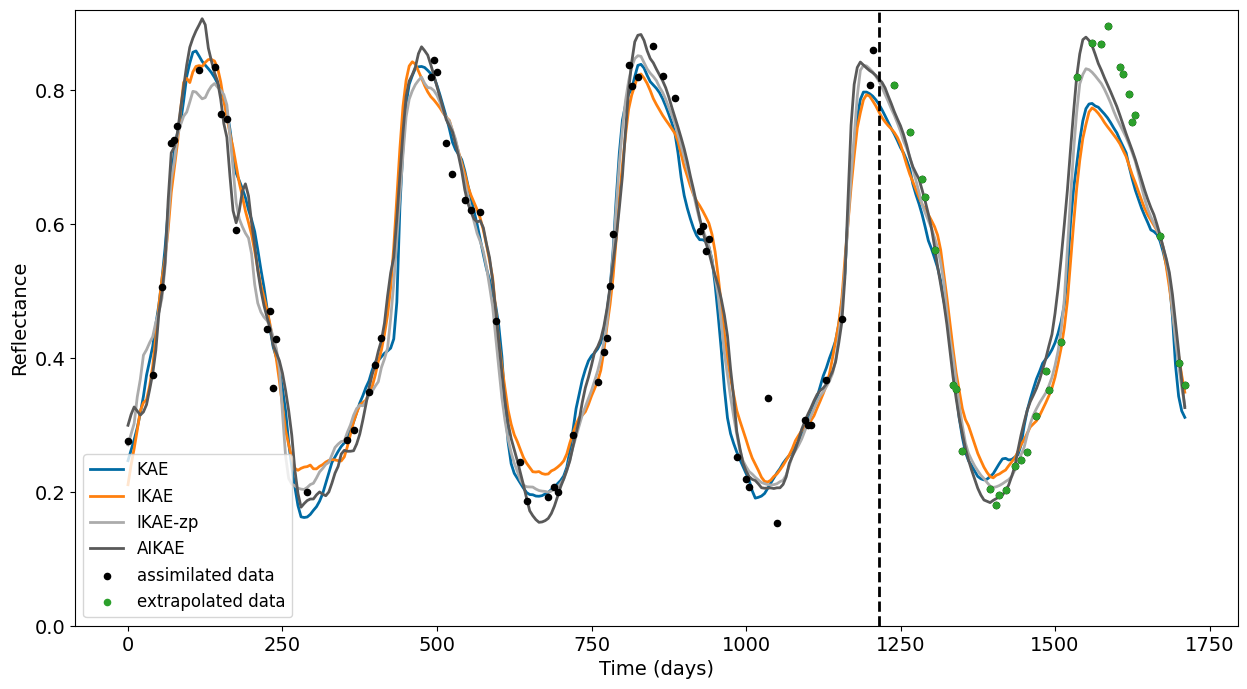

In [37]:
# This cell reproduces figure 3 from the pre-print
test_pixel = (18,90) # Gives the figure from the pre-print
X = np.array([5*k for k in range(reflectances.shape[3])])
print(test_pixel)
band = 6

plt.style.use('tableau-colorblind10')
plt.figure(figsize=(15,8))
plt.ylim(0, 0.92)
plt.xlabel('Time (days)', size=14)
plt.ylabel('Reflectance', size=14)

plt.plot(X, predictions_KAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='KAE')
plt.plot(X, predictions_IKAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='IKAE') # Uncomment to the the IKAE result
plt.plot(X, predictions_IKAE_zp[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='IKAE-zp')
plt.plot(X, predictions_AIKAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='AIKAE')
plt.scatter(X[mask_test==1], reflectances_test[band,test_pixel[0],test_pixel[1],:][mask_test==1], s=20, c='black', label='assimilated data', zorder=4)
plt.scatter(X[-100:][mask_test[-100:]==1], reflectances_test[band,test_pixel[0],test_pixel[1],-100:][mask_test[-100:]==1], s=20, c='tab:green', label='extrapolated data', zorder=4)
plt.axvline(X[-100], 0, 1, c='black', linestyle='dashed', linewidth=2)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize=12, loc='lower left')

plt.savefig('Assimilation-forecasting.pdf', bbox_inches='tight')

Visualisation for spectral band 3 on pixel (15, 7)


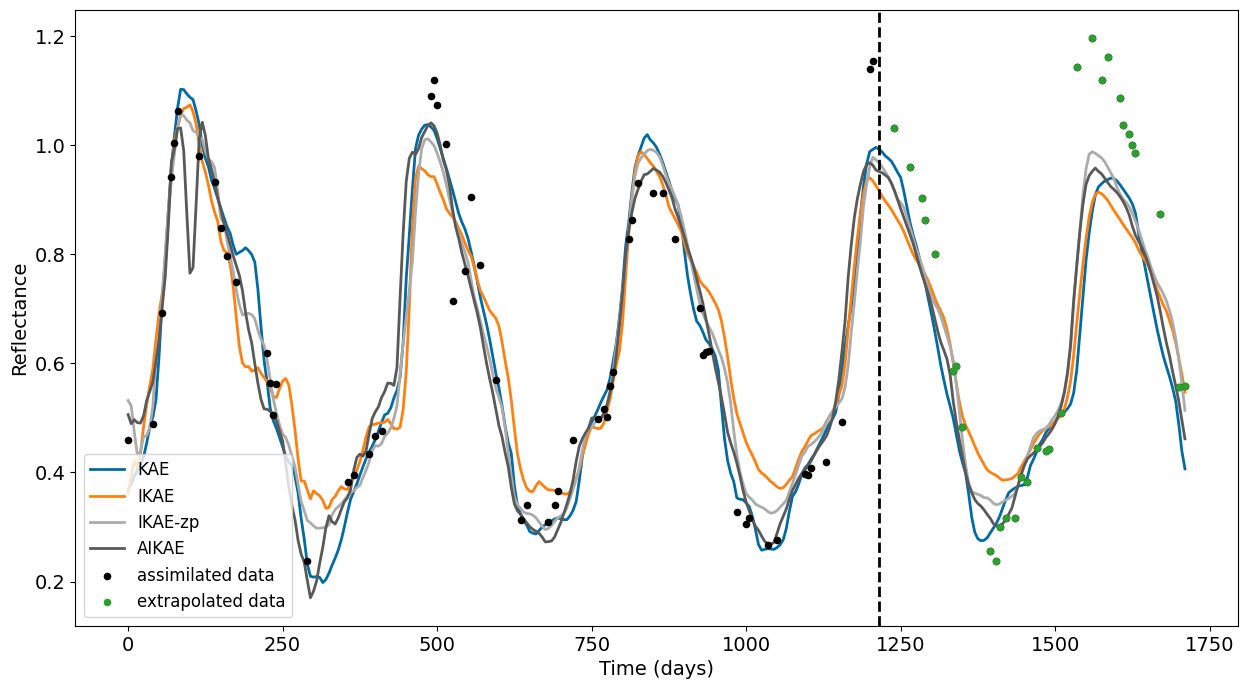

In [49]:
# This cell shows a similar visualisation, for a random pixel and spectral band
test_pixel = (rd.randint(0,size-1), rd.randint(0, size-1))
X = np.array([5*k for k in range(reflectances.shape[3])])
band = rd.randint(0, 9)
print(f"Visualisation for spectral band {band} on pixel {test_pixel}")

plt.style.use('tableau-colorblind10')
plt.figure(figsize=(15,8))
plt.xlabel('Time (days)', size=14)
plt.ylabel('Reflectance', size=14)

plt.plot(X, predictions_KAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='KAE')
plt.plot(X, predictions_IKAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='IKAE') # Uncomment to the the IKAE result
plt.plot(X, predictions_IKAE_zp[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='IKAE-zp')
plt.plot(X, predictions_AIKAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='AIKAE')
plt.scatter(X[mask_test==1], reflectances_test[band,test_pixel[0],test_pixel[1],:][mask_test==1], s=20, c='black', label='assimilated data', zorder=4)
plt.scatter(X[-100:][mask_test[-100:]==1], reflectances_test[band,test_pixel[0],test_pixel[1],-100:][mask_test[-100:]==1], s=20, c='tab:green', label='extrapolated data', zorder=4)
plt.axvline(X[-100], 0, 1, c='black', linestyle='dashed', linewidth=2)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize=12)

plt.savefig('Assimilation-forecasting.pdf', bbox_inches='tight')